In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import Xception
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from skimage.transform import resize


In [4]:
train_dir='/content/drive/MyDrive/Training'
test_dir='/content/drive/MyDrive/Testing'
labels=['glioma', 'meningioma', 'notumor', 'pituitary']
image_size=224

In [5]:
def load_images_from_folder(folder, labels, image_size):
  X=[]
  Y=[]
  for label in labels:
    path=os.path.join(folder, label)
    class_num=labels.index(label)
    for img in os.listdir(path):
      img_array=plt.imread(os.path.join(path, img))
      img_resized=resize(img_array, (image_size, image_size, 3))
      X.append(img_resized)
      Y.append(class_num)
  return np.array(X), np.array(Y)

In [8]:
X_train, Y_train=load_images_from_folder(train_dir, labels, image_size)
X_test, Y_test=load_images_from_folder(test_dir, labels, image_size)

X_train, Y_train=shuffle(X_train, Y_train, random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [10]:
datagen=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [25]:
datagen.fit(X_train)

y_train_new=tf.keras.utils.to_categorical(Y_train, num_classes=4)
y_valid_new=tf.keras.utils.to_categorical(Y_valid, num_classes=4)
y_test_new=tf.keras.utils.to_categorical(Y_test, num_classes=4)


base_model=Xception(input_shape=(image_size, image_size, 3),
                    include_top=False, weights='imagenet')
base_model.trainable=False


model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint=ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


history=model.fit(
    datagen.flow(X_train, y_train_new, batch_size=32),
    epochs=50,
    validation_data=(X_valid, y_valid_new),
    callbacks=[early_stopping, checkpoint]
)

val_loss, val_accuracy=model.evaluate(X_valid, y_valid_new)
test_loss, test_accuracy=model.evaluate(X_test, y_test_new)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 623ms/step - accuracy: 0.7675 - loss: 0.7711 - val_accuracy: 0.8923 - val_loss: 0.3457
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 617ms/step - accuracy: 0.8938 - loss: 0.3262 - val_accuracy: 0.9200 - val_loss: 0.2361
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 616ms/step - accuracy: 0.9046 - loss: 0.2774 - val_accuracy: 0.9262 - val_loss: 0.2240
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 612ms/step - accuracy: 0.9153 - loss: 0.2237 - val_accuracy: 0.9354 - val_loss: 0.2095
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 606ms/step - accuracy: 0.9323 - loss: 0.1820 - val_accuracy: 0.9385 - val_loss: 0.2182
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 605ms/step - accuracy: 0.9263 - loss: 0.1926 - val_accuracy: 0.9385 - val_loss: 0.2125
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 607ms/step - accuracy: 0.9358 - loss: 0.1782 - val_accuracy: 0.9508 - val_loss: 0.2101
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 617ms/step - accuracy: 0.9441 - loss: 0.1558 - val_accuracy: 0.916

In [26]:
y_pred=model.predict(X_test)
y_pred_classes=np.argmax(y_pred, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 563ms/step


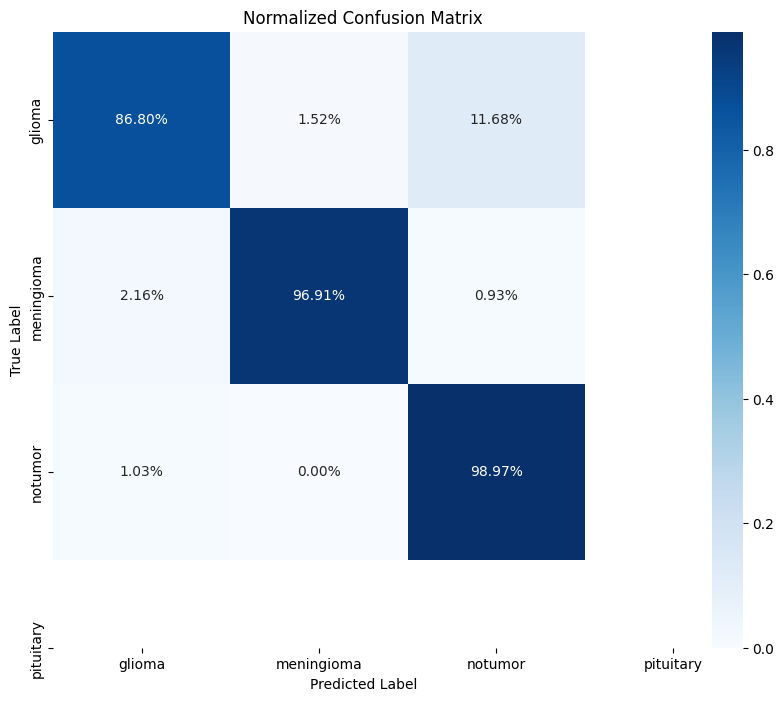

In [27]:
cm=confusion_matrix(Y_test, y_pred_classes)
cm_percentage=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


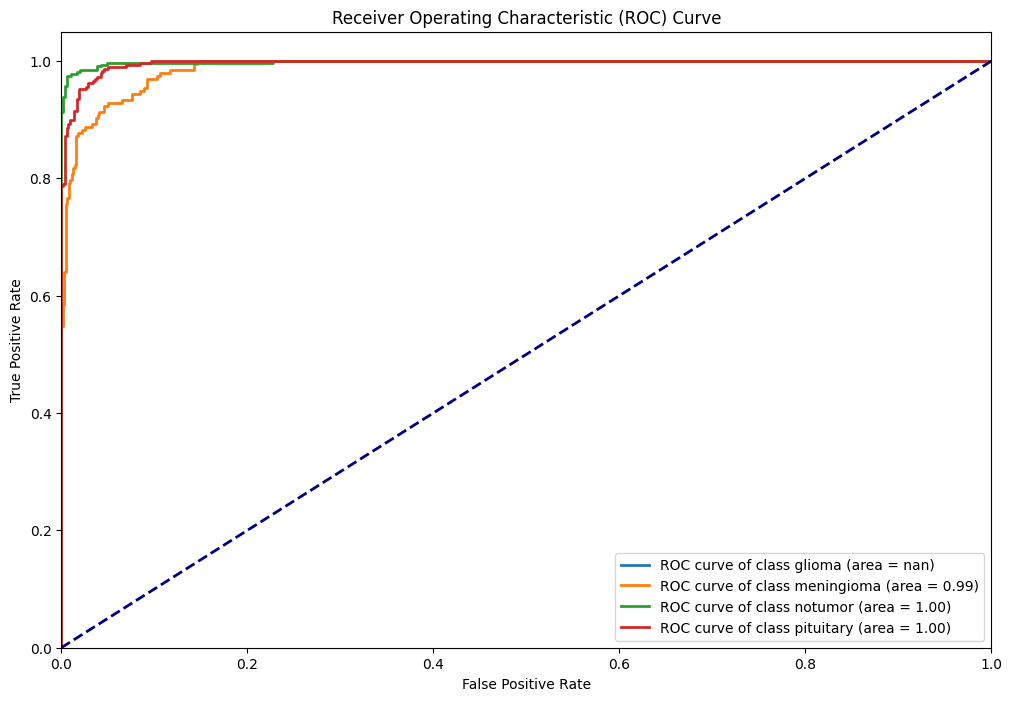

In [28]:
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_new[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of class {label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


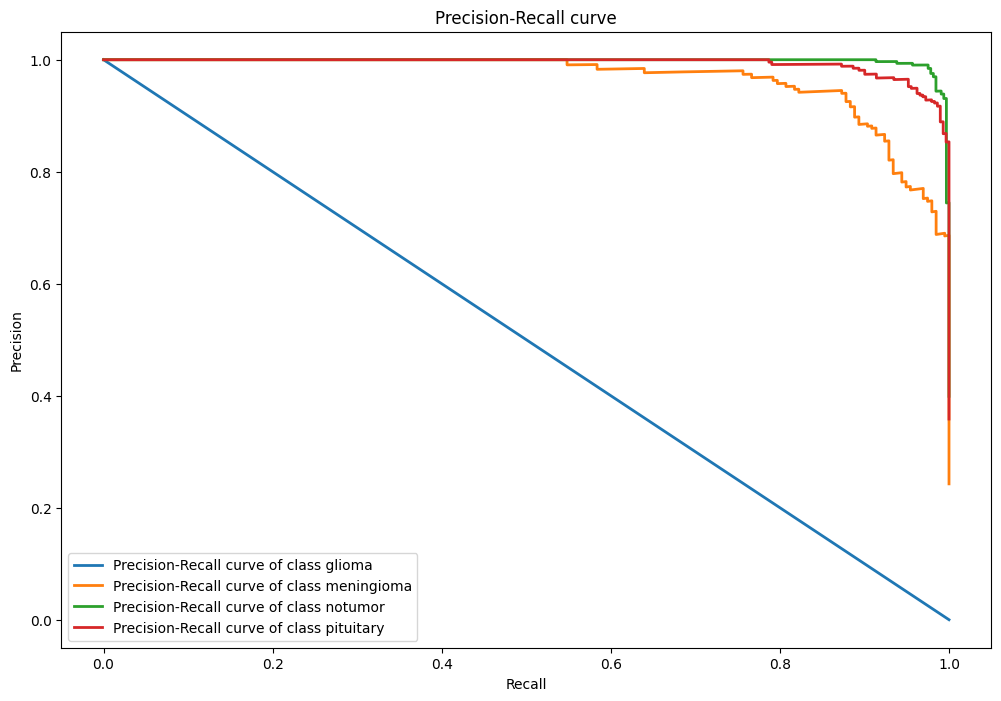

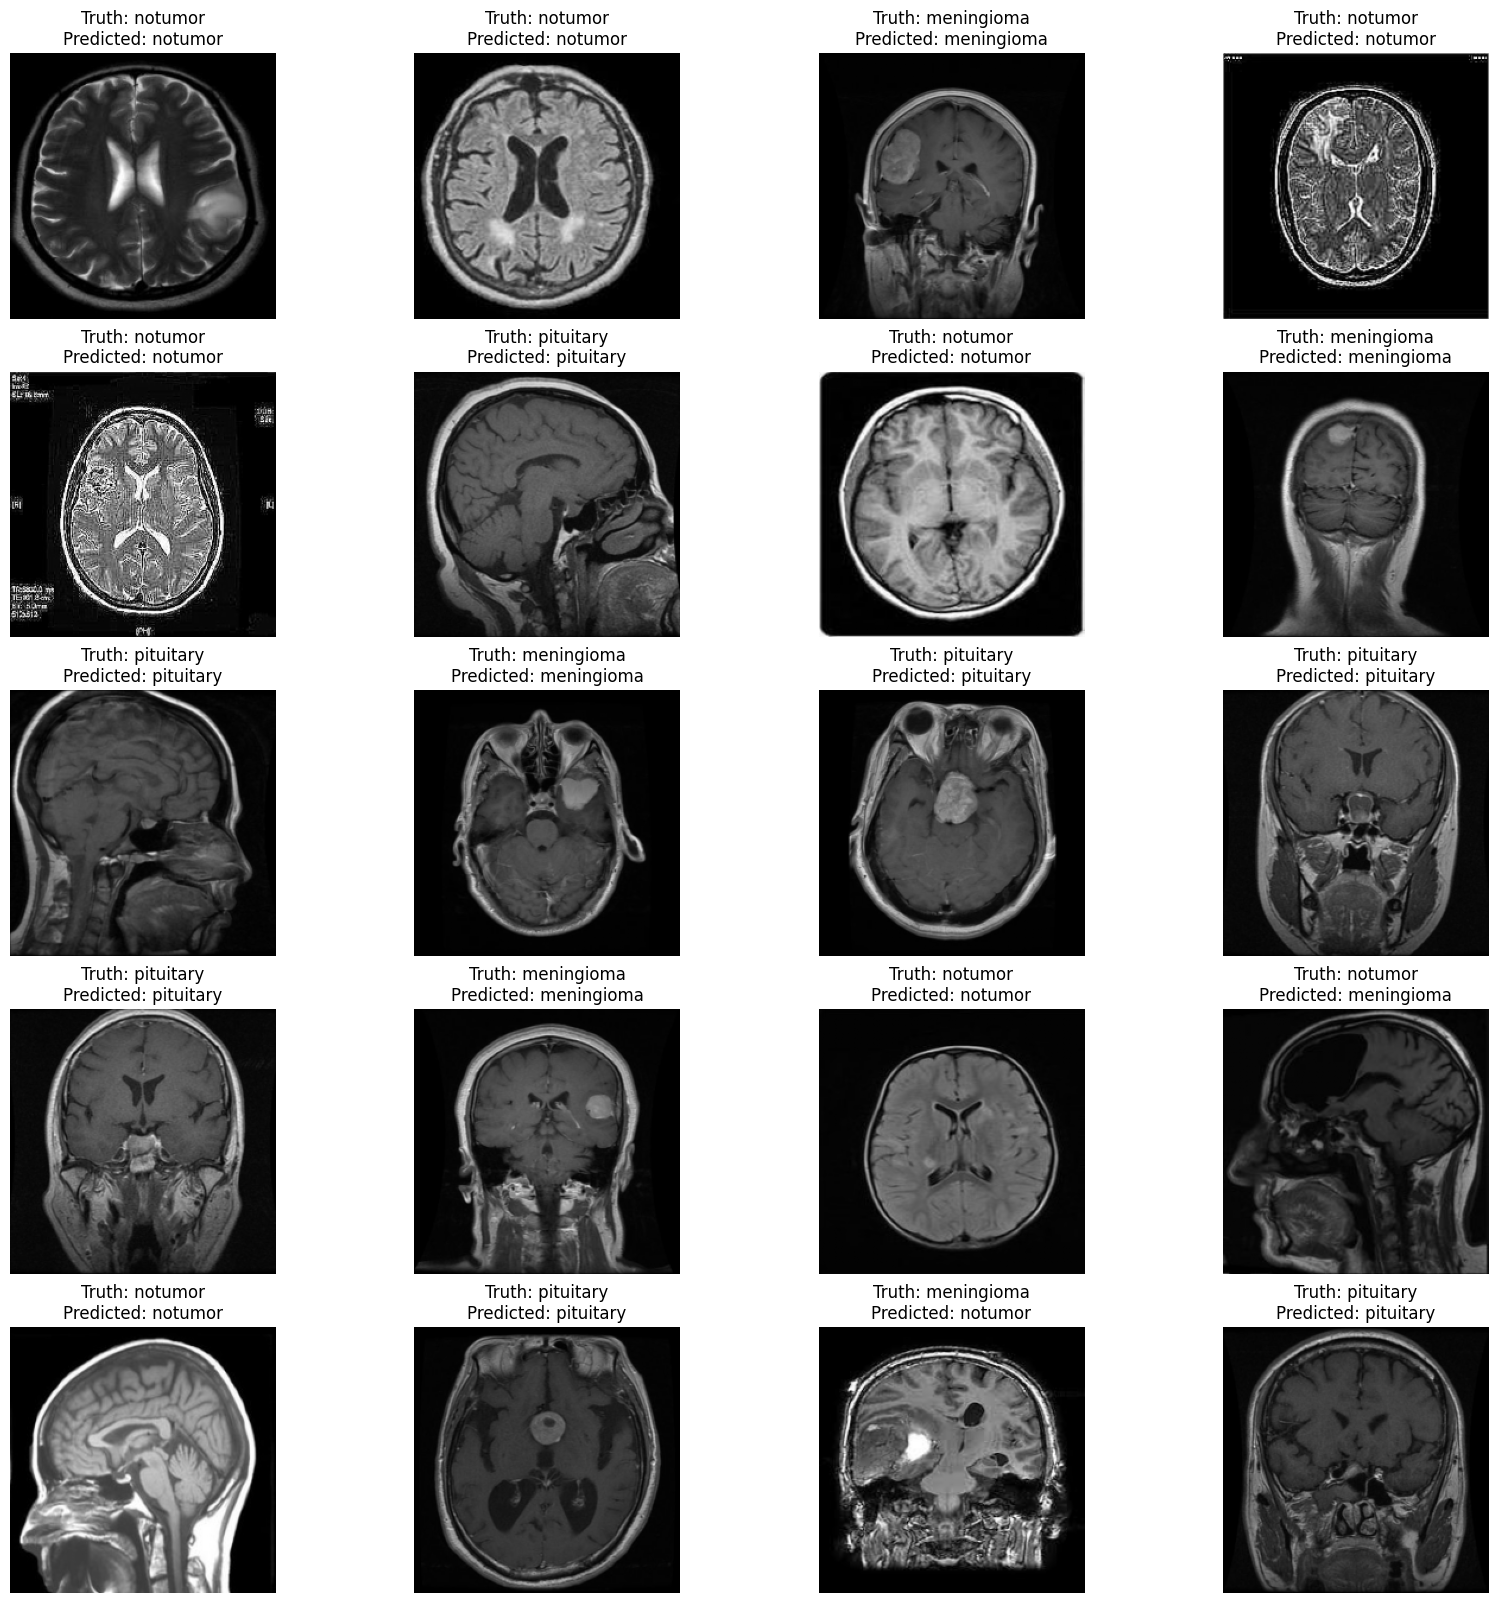

In [29]:
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    precision, recall, _ = precision_recall_curve(y_test_new[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve of class {label}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="best")
plt.show()

# Save the model
model.save('best_model_with_visualizations.keras')

# Visualize predictions
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Truth: {labels[Y_test[i]]}\nPredicted: {labels[y_pred_classes[i]]}")
    plt.axis('off')
plt.show()